In [1]:
from utils.binaries import *
from utils.plotting import *

09:03:33 (+7525.4s) [INFO   ] -- import logging
09:03:33 (  +105ms) [INFO   ] -- import numpy as np
09:03:33 (    +9ms) [INFO   ] -- import uncertainties
09:03:33 (  +172ms) [INFO   ] -- import pandas as pd
09:03:33 (    +2ms) [INFO   ] -- import binaries.tools as tools
09:03:33 (  +292ms) [INFO   ] -- import matplotlib.pyplot as plt
09:03:34 (  +361ms) [INFO   ] -- import seaborn as so
09:03:34 (    +7ms) [DEBUG  ] -- font size set to 9.5
09:03:34 (    +1ms) [DEBUG  ] -- label size set to 13.0
09:03:34 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
09:03:34 (    +1ms) [DEBUG  ] -- markersize set to 2.0
09:03:34 (    +0ms) [DEBUG  ] -- usetex set to False
09:03:34 (    +3ms) [INFO   ] -- import plotting.tools as plot


In [2]:
def read_file(path_to_file):
    
    with open(path_to_file, 'r') as file:
        traces = file.readlines()[1:]

    for i, trace in enumerate(traces[:-1]):
        trace_formatted = trace.rstrip().split(',')
        baseline, start, stop, n_, *trace = trace_formatted
        baseline = float(baseline)
        traces[i] = np.array([float(x) - baseline for x in trace])

    return [traces[i:i+3] for i in range(0, len(traces), 3)][:-1]

def plot_test_trace(trace):
    pmt1, pmt2, pmt3 = trace
    plt.plot(range(len(pmt1)), pmt1, label='pmt1')
    plt.plot(range(len(pmt1)), pmt2, label='pmt2')
    plt.plot(range(len(pmt1)), pmt3, label='pmt3')

In [5]:
wcd_traces = read_file('dump_trace-uub-hw_wcdLarge-full_0-fast_1.dat')

3 1000 1000 1000
3 1000 1000 1000


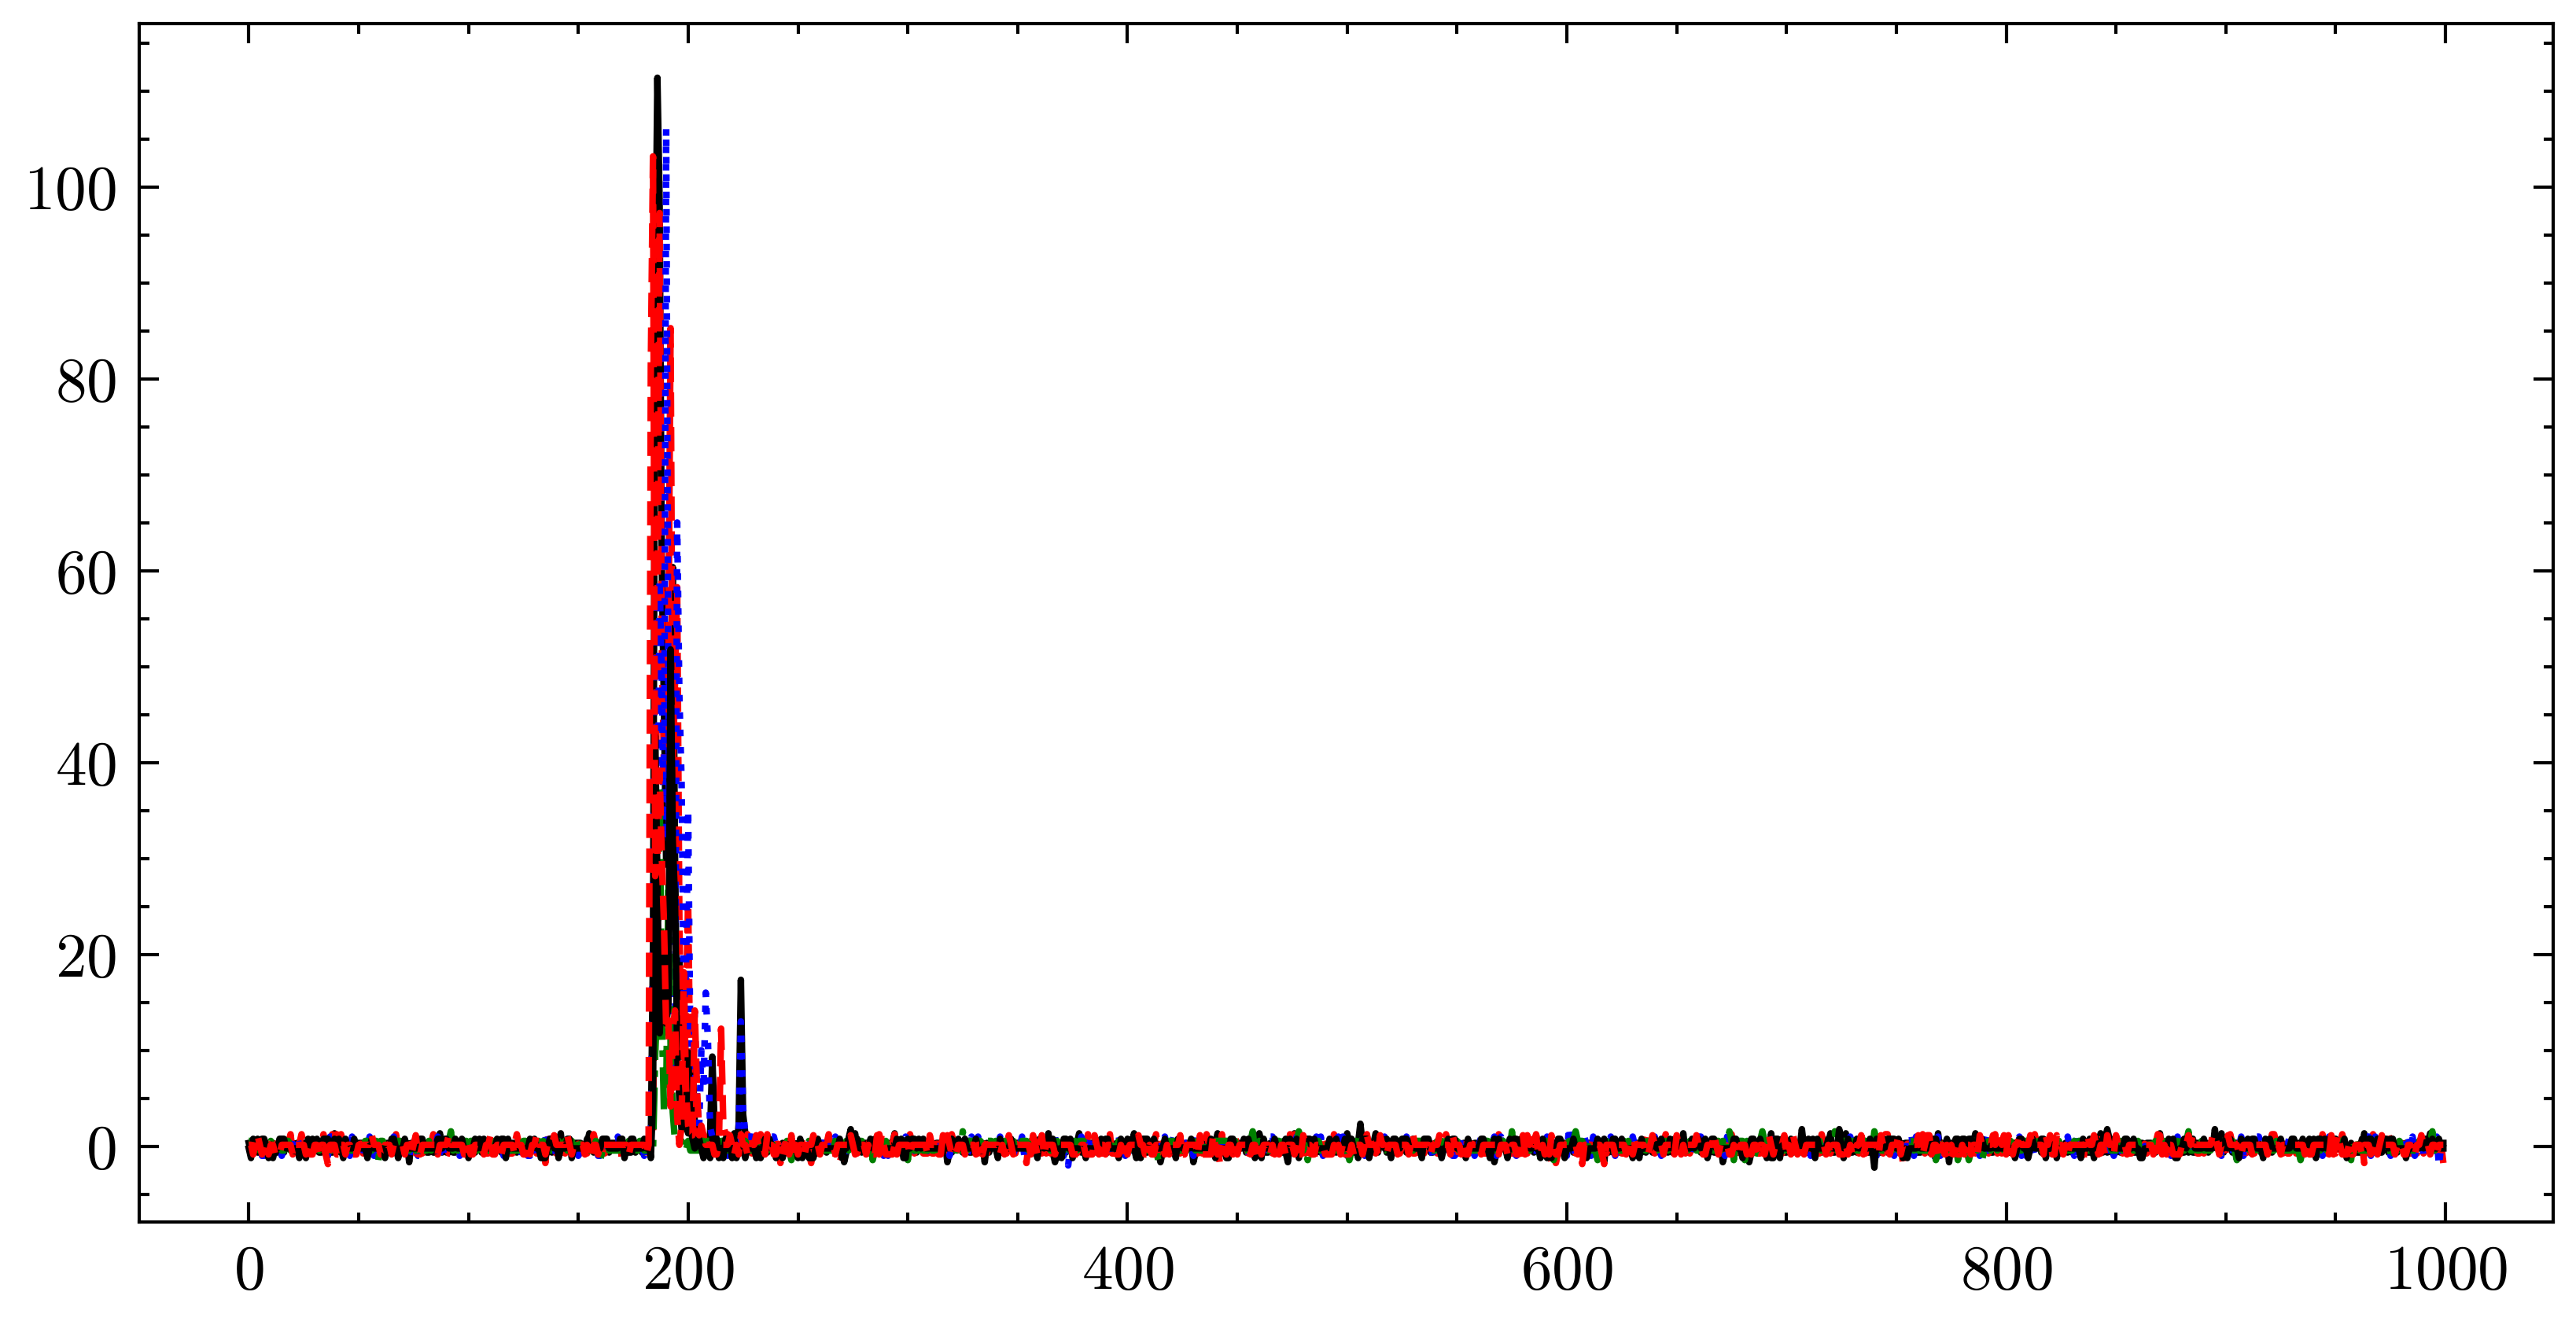

In [6]:
for trace in wcd_traces:
    print(len(trace), len(trace[0]), len(trace[1]), len(trace[2]))
    plot_test_trace(trace)
    # break

In [145]:
print(len(wcd_traces))

2


In [146]:
print(len(wcd_traces[4][1]))

IndexError: list index out of range